# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score

from art.utils import load_cifar10
from art.defences.preprocessor import MixupTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
tf.config.run_functions_eagerly(True)

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# MixUp

In [3]:
mixup = MixupTensorFlowV2(num_classes=10, alpha=0.3, num_mix=2, apply_fit=True, apply_predict=False)

In [4]:
mixup_train = mixup.forward(x=x_train, y=y_train)

In [5]:
mixup_test = mixup.forward(x=x_test, y=y_test)

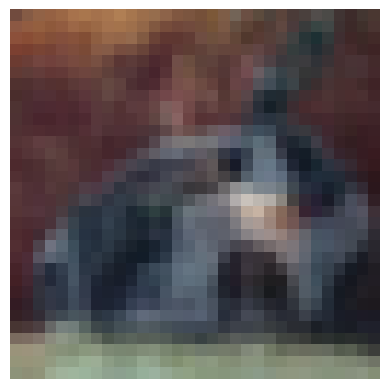

In [6]:
plt.figure()
plt.imshow(mixup_test[0][6])
plt.axis("off")
plt.show()

# Model

In [7]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
normal_model = create_model()

In [9]:
augmented_model = create_model()

# Train - Normal Model

In [10]:
history = normal_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


/home/alper/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


391/391 [==============================] - 20s 49ms/step - loss: 1.4042 - accuracy: 0.4953 - val_loss: 1.0775 - val_accuracy: 0.6220
Epoch 2/10
391/391 [==============================] - 18s 45ms/step - loss: 0.9491 - accuracy: 0.6655 - val_loss: 0.9088 - val_accuracy: 0.6777
Epoch 3/10
391/391 [==============================] - 18s 46ms/step - loss: 0.7558 - accuracy: 0.7366 - val_loss: 0.7685 - val_accuracy: 0.7325
Epoch 4/10
391/391 [==============================] - 17s 45ms/step - loss: 0.6061 - accuracy: 0.7883 - val_loss: 0.7568 - val_accuracy: 0.7478
Epoch 5/10
391/391 [==============================] - 18s 46ms/step - loss: 0.4657 - accuracy: 0.8375 - val_loss: 0.7797 - val_accuracy: 0.7429
Epoch 6/10
391/391 [==============================] - 18s 45ms/step - loss: 0.3360 - accuracy: 0.8840 - val_loss: 0.7866 - val_accuracy: 0.7475
Epoch 7/10
391/391 [==============================] - 17s 44ms/step - loss: 0.2169 - accuracy: 0.9249 - val_loss: 0.9156 - val_accuracy: 0.7498
Epo

# Train - Augmented Model

In [11]:
history = augmented_model.fit(mixup_train[0], y_train, batch_size=128, epochs=10, validation_data=(mixup_test[0], y_test))

Epoch 1/10
391/391 [==============================] - 17s 44ms/step - loss: 1.4274 - accuracy: 0.4836 - val_loss: 2.7866 - val_accuracy: 0.1899
Epoch 2/10
391/391 [==============================] - 18s 45ms/step - loss: 0.9484 - accuracy: 0.6660 - val_loss: 3.2090 - val_accuracy: 0.1984
Epoch 3/10
391/391 [==============================] - 17s 44ms/step - loss: 0.7473 - accuracy: 0.7403 - val_loss: 3.3708 - val_accuracy: 0.1943
Epoch 4/10
391/391 [==============================] - 19s 48ms/step - loss: 0.6058 - accuracy: 0.7897 - val_loss: 3.9714 - val_accuracy: 0.1962
Epoch 5/10
391/391 [==============================] - 18s 47ms/step - loss: 0.4687 - accuracy: 0.8373 - val_loss: 4.2018 - val_accuracy: 0.1938
Epoch 6/10
391/391 [==============================] - 19s 48ms/step - loss: 0.3430 - accuracy: 0.8812 - val_loss: 5.3411 - val_accuracy: 0.1893
Epoch 7/10
391/391 [==============================] - 18s 46ms/step - loss: 0.2288 - accuracy: 0.9209 - val_loss: 5.4947 - val_accuracy:

# Test 

In [12]:
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

In [13]:
normal_pred1 = normal_model.predict(x_test, verbose=0)
normal_pred1 = np.argmax(normal_pred1, axis=1)

In [14]:
normal_pred2 = normal_model.predict(mixup_test[0], verbose=0)
normal_pred2 = np.argmax(normal_pred2, axis=1)

In [15]:
augmented_pred1 = augmented_model.predict(x_test, verbose=0)
augmented_pred1 = np.argmax(augmented_pred1, axis=1)

In [16]:
augmented_pred2 = augmented_model.predict(mixup_test[0], verbose=0)
augmented_pred2 = np.argmax(augmented_pred2, axis=1)

# Results

In [17]:
print("Normal Model Accuracy (Normal Data):", accuracy_score(y_test_true, normal_pred1))
print("Normal Model Accuracy (Augmented Data):", accuracy_score(y_test_true, normal_pred2))

Normal Model Accuracy (Normal Data): 0.7431
Normal Model Accuracy (Augmented Data): 0.1868


In [18]:
print("Augmented Model Accuracy (Normal Data):", accuracy_score(y_test_true, augmented_pred1))
print("Augmented Model Accuracy (Augmented Data):", accuracy_score(y_test_true, augmented_pred2))

Augmented Model Accuracy (Normal Data): 0.723
Augmented Model Accuracy (Augmented Data): 0.1853
